# Prediction of biological activity of estrogen receptor alpha inhibitors

**MI-ADM.16**, final project  
**Computational drug design**, final project

**Jiří Reiniš**  
University of Chemistry and Technology, Prague  
Faculty of Information Technology, Czech Technical University in Prague

**June 2, 2019**

<img src="data/ERA.png" alt="Drawing" align="right" style="height: 220px;"/> 
<img src="data/receptor.png" alt="Drawing" align="right" style="height: 220px;"/>  


## Introduction

### Estrogen receptor alpha (ERα)
- nuclear protein, plays a role in the physiological development and function of a variety of organ systems
- https://en.wikipedia.org/wiki/Estrogen_receptor_alpha    



### Inhibitors
- small molecules binding to a target protein and decreasing its function
- the biological activity of an inhibitor can be quantified by its potency
- the potency of an inhibitor is measured by $\text{IC}_{50}$ (half maximum inhibitory concentration)
    - simplified definition: concentration of inhibitor required to reach 50% of a defined maximum inhibition effect
    - $\text{IC}_{50}$ decreases with increasing inhibitor potency



## Dataset

- a set of ligands (small molecules binding to our target protein, estrogen receptor alpha) and their:
    - experimentally determined $\text{IC}_{50}$ values.
    - chemical structure, encoded as text in [SMILES] (simplified molecular-input line-entry system):  
        - e.g. `CCc(c1)ccc2[n+]1ccc3c2[nH]c4c3cccc4`

[SMILES]:https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system



### Data source: ChEMBL database
- ChEMBL is a database of bioactive drug-like small molecules at the European Bioinformatics Institute (EBI)
- inhibitors of ERα with measured IC50:  
https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/target_chembl_id%3ACHEMBL206%20AND%20standard_type%3A(%22IC50%22)

## Prediction task:

- based on structure, predict inhibitor potency
- structure of each ligand will be encoded as a 1024 bit vector (Morgan Fingerprint) generated by [RDKit library](http://rdkit.org/):  

#### 1. Regression: predict pChEMBL value

- instead of predicting directly $\text{IC}_{50}$, we will predict $\text{pChEMBL}$ value:
- $\text{pChEMBL} = -\log({\text{IC}}_{50})$
- increases with inhibitor potency
  
  
- Random Forests
- XGBoost
- MLP


#### 2. Binary classification: active/inactive ligand:

- threshold of $\text{pChEMBL}$ values:
    - active: $\text{pChEMBL} \geq 6.5$
    - inactive: $\text{pChEMBL} < 6.5$  
    
    - threshold selected based on this publication:  
    https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0232-0
    
  
- Logistic regression
- Random Forests
- Naive Bayes
- MLP (Keras sequential model)


## Results:

#### 1. Regression: predict pChEMBL value

| Method                                 | RMSLE  | $r^2$    |
|---------------------------------------|--------|--------|
| **Random Forests (default parameters)**| 0.865  | 0.629  |
| **Random Forests (tuned)**             | 0.784  | 0.678  |
| **XGBoost (default parameters)**       | 0.808  | 0.658  |
| **XGBoost (tuned)**                    | **0.757**  | **0.700**  |
| **MLP (default parameters)**           | 0.893  | 0.582  |
| **MLP (tuned)**                        | 0.814  | 0.653  |

#### 2. Binary classification: active/inactive ligand:

| Method                                 | Accuracy |
|----------------------------------------|----------|
| **Logistic regression**                | 0.823    |
| **Random Forests**                     | **0.832**    |
| **Naive Bayes**                        | 0.815    |
| **MLP (Keras sequential model)**       | 0.829    | 

## Data import, preprocessing

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
import molvs

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix

import xgboost

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy, binary_crossentropy

Using TensorFlow backend.


In [2]:
data_raw = pd.read_csv('data/CHEMBL206_ERA_ligands_activity_IC50_parsed.csv', delimiter="|")

In [3]:
data_raw.head()

,Molecule,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Comment,Compound_Key,Assay,Assay_Description,...,Published_Relation,Published_Value,Published_Units,Canonical_Smiles,Data_Validity_Comment,Document_Journal,Document_Year,SRC_ID,UO_Units,Potential_Duplicate
0,CHEMBL222522,IC50,=,59.0,nM,7.23,NaN,11h,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,...,NaN,NaN,NaN,Cc1cc(O)ccc1c2nn(CC=C)c3c(cccc23)C(F)(F)F,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
1,CHEMBL373743,IC50,=,18.0,nM,7.75,NaN,11f,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,...,NaN,NaN,NaN,Oc1ccc(cc1)c2nn(C3CCCC3)c4c(F)cccc24,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
2,CHEMBL221676,IC50,=,196.0,nM,6.71,NaN,8c,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,...,NaN,NaN,NaN,Oc1ccc(cc1)c2nn(Cc3ccccc3)c4c(cccc24)C(F)(F)F,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
3,CHEMBL225022,IC50,=,112.0,nM,6.95,NaN,4e,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,...,NaN,NaN,NaN,CCCCn1nc(c2ccc(O)cc2O)c3ccc(O)cc13,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
4,CHEMBL225514,IC50,=,62.0,nM,7.21,NaN,4d,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,...,NaN,NaN,NaN,CCCn1nc(c2ccc(O)cc2O)c3ccc(O)cc13,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False


### Clean data, remove duplicates

In [4]:
data = data_raw.copy()

In [5]:
data = data[data['Canonical_Smiles'].notnull()]
data = data[data['pChEMBL_Value'].notnull()]
data = data[data['Standard_Value'].notnull()]
data = data[data['Standard_Relation'] == "="]
data = data[data['Potential_Duplicate']==False]
data = data.reset_index(drop=True)
data = data.copy()

### Generate RDKit molecule object from SMILES text representation of structure

In [6]:
data["Molecule"] = [Chem.MolFromSmiles(mol) for mol in data["Canonical_Smiles"]]

### Example visualization of a few ligands in our dataset

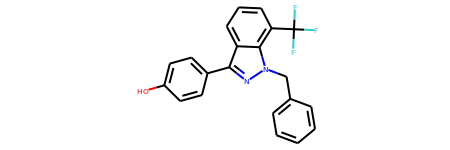

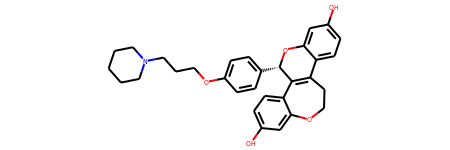

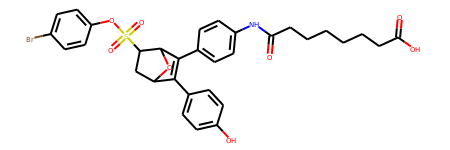

In [7]:
display(data.iloc[2]["Molecule"])
display(data.iloc[100]["Molecule"])
display(data.iloc[678]["Molecule"])

### Data standardization (from chemical point of view)
#### Standardize molecules and remove inorganic compounds

In [8]:
isOrganic = Chem.MolFromSmarts('[#6]')
hasInorganic = Chem.MolFromSmarts('[!#6;!#7;!#8;!#16;!Cl;!F;!Br;!I]')

_s = molvs.Standardizer()
def standardization(mol):
    mol = _s.standardize(mol)
    mol = _s.fragment_parent(mol)
    if mol.HasSubstructMatch(isOrganic) and not mol.HasSubstructMatch(hasInorganic):
        mol = _s.charge_parent(mol)
        mol = _s.stereo_parent(mol)
        return mol
    else:
        return None

In [9]:
data['Standardized'] = [standardization(mol) for mol in data["Molecule"]]

RDKit ERROR: [09:04:23] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [09:04:23] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [09:04:23] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [09:04:23] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [09:04:23] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


In [10]:
data = data[data['Standardized'].notna()].copy()

### Generate Morgan fingerprints

After this key step, ligand structure will be represented as a binary vector of length 1024.

In [11]:
data['FP2'] = [np.asarray(Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)) for mol in data['Standardized']]

### Add binary label (active/inactive)

In [12]:
cutoff = 6.5
data['label'] = ['active' if x >= cutoff else 'inactive' for x in data['pChEMBL_Value']]

In [13]:
data = data[['Canonical_Smiles', 'FP2', 'pChEMBL_Value', 'label']]

In [16]:
data = data.reset_index(drop=True)
data = data.copy()

In [17]:
data.tail(n=10)

,Canonical_Smiles,FP2,pChEMBL_Value,label
2283,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.11,active
2284,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.30,inactive
2285,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@H]34)[C@...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.09,inactive
2286,Oc1ccc(cc1)[C@@H]2CC(=O)c3c(O)cc(O)cc3O2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.12,inactive
2287,Oc1ccc(cc1)c2sc3cc(O)ccc3c2C(=O)c4ccc(OCCN5CCC...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...",7.62,active
2288,C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc34)[C@@H]1CC...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.80,active
2289,C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc34)[C@@H]1CC...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.85,active
2290,CC\C(=C(/c1ccccc1)\c2ccc(OCCN(C)C)cc2)\c3ccccc3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",7.00,active
2291,Oc1ccc(cc1)c2sc3cc(O)ccc3c2C(=O)c4ccc(OCCN5CCC...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...",9.33,active
2292,Oc1ccc(cc1)c2sc3cc(O)ccc3c2C(=O)c4ccc(OCCN5CCC...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...",7.69,active


#### Save preprocessed table

In [15]:
data_to_save = data.copy()
data_to_save['FP2'] = ["".join((str(x) for x in xs)) for xs in data_to_save['FP2']]
data_to_save.to_csv('data/CHEMBL206_ERA_ligands_activity_IC50_preprocessed.csv', index = False)

#### Load preprocessed table

In [27]:
data = pd.read_csv('data/CHEMBL206_ERA_ligands_activity_IC50_preprocessed.csv')
f = [x for x in data['FP2']]
f = [np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in f]
data['FP2'] = f

train, test = train_test_split(data, test_size=0.3, random_state=666)
train, test = train.copy(), test.copy()

X_train = [fp for fp in train['FP2']]
X_test = [fp for fp in test['FP2']]
y_train = [value for value in train['pChEMBL_Value']]
y_test = [value for value in test['pChEMBL_Value']]

## Train-test split

In [41]:
train, test = train_test_split(data, test_size=0.3, random_state=666)
train, test = train.copy(), test.copy()

X_train = [fp for fp in train['FP2']]
X_test = [fp for fp in test['FP2']]

## Regressors (predicting directly pChEMBL value)

In [42]:
y_train = [value for value in train['pChEMBL_Value']]
y_test = [value for value in test['pChEMBL_Value']]

#### Metrics function

In [43]:
def show_regressor_metrics(regressor, X_test, y_test):
    y_pred = regressor.predict(X_test)

    sns.scatterplot(x=y_test, y=y_pred)

    print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("r^2:  {}".format(r2_score(y_test, y_pred)))

### Random forests

#### Default parameters

In [44]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RMSE: 0.8654557438881213
r^2:  0.6288831389932521


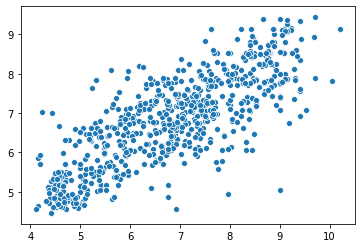

In [45]:
show_regressor_metrics(rfr, X_test, y_test)

In [46]:
rfr_params = {'n_estimators': [5, 10, 50, 100, 150, 200, 300],
              'max_depth': [3, 5, 7, 9, 12]}

#### Parameter tuning

In [81]:
%%time

rfr2 = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfr_params, cv=10)
rfr2.fit(X_train,y_train)

CPU times: user 24min 24s, sys: 759 ms, total: 24min 25s
Wall time: 24min 25s


In [86]:
best_parameters=rfr2.best_estimator_.get_params()
for param_name in sorted(rfr_params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	max_depth: 9
	n_estimators: 100


RMSE: 0.7841905858074497
r^2:  0.6782242181023211


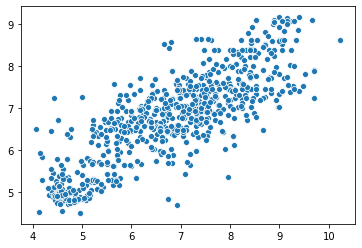

In [88]:
show_regressor_metrics(rfr2, X_test, y_test)

### Gradient boosting (XGBoost)

#### Default parameters

In [89]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

RMSE: 0.8079283269249263
r^2:  0.6584488308798957


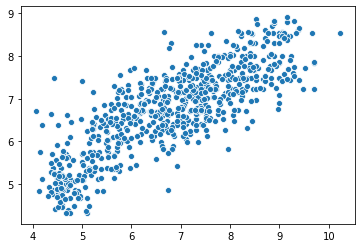

In [90]:
show_regressor_metrics(xgb_reg, X_test, y_test)

#### Parameter tuning

In [5]:
parameters_xgb = {'n_estimators': [5, 10, 50, 100, 150, 200],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                  'gamma':[0, 0.01, 0.1, 0.2],
                  'objective': ['reg:linear']}

In [6]:
%%time
xgb_reg2 = GridSearchCV(estimator=xgboost.XGBRegressor(), param_grid=parameters_xgb, cv=10, n_jobs=2, verbose=1)
xgb_reg2.fit(X_train,y_train)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   54.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 12.0min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 15.7min
[Parallel(n_jobs=2)]: Done 3600 out of 3600 | elapsed: 17.9min finished


CPU times: user 6min 56s, sys: 2.54 s, total: 6min 59s
Wall time: 17min 53s


In [21]:
best_parameters=xgb_reg2.best_estimator_.get_params()
for param_name in sorted(parameters_xgb.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	gamma: 0.2
	learning_rate: 0.1
	max_depth: 5
	n_estimators: 200
	objective: 'reg:linear'


RMSE: 0.7573429868279177
r^2:  0.6998797345516647


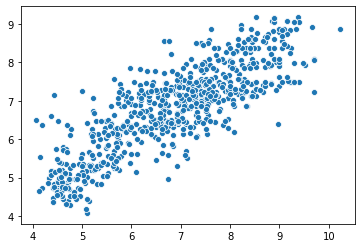

In [22]:
show_regressor_metrics(xgb_reg2, X_test, y_test)

### MLP

#### Default parameters

In [3]:
mlp_reg = MLPRegressor(max_iter=400)
mlp_reg.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=400, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

RMSE: 0.8932836527772322
r^2:  0.5824688530257794


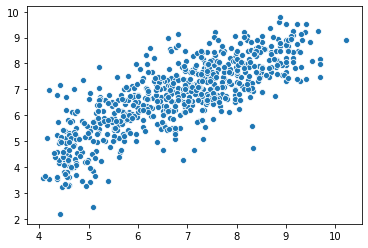

In [99]:
show_regressor_metrics(mlp_reg, X_test, y_test)

#### Parameter tuning

In [3]:
parameters_mlp = {'alpha': [1, 0.1, 0.01, 0.001, 0],
                  'activation': ['tanh', 'relu', 'logistic'],
                  'solver': ['sgd', 'adam', 'lbfgs'],
                  'learning_rate': ['constant','adaptive'],}      

In [8]:
%%time
mlp_reg = MLPRegressor(max_iter=600)
mlp_reg2 = GridSearchCV(estimator=mlp_reg, param_grid=parameters_mlp, cv=5, verbose=2)
mlp_reg2.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=sgd ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.8s remaining:    0.0s


[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=sgd, total=  33.8s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=sgd, total=  34.3s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=sgd, total=  35.5s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=sgd, total=  35.8s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=sgd, total=  35.8s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=adam, total=  19.3s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=adam, total=  20.5s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=adam, total=  20.4s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=adam, total=  21.6s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=adam, total=  18.8s
[CV] activation=tanh, alpha=1, learning_rate=constant, solver=lbfgs ..
[CV]  activation=tanh, alpha=1, learning_rate=constant, solver=lbfgs, total= 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd, total=  36.5s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd, total=  35.4s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd, total=  35.7s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd, total=  37.1s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=sgd, total=  35.2s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=adam, total=  19.2s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=adam, total=  18.1s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=adam, total=  16.6s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=adam, total=  18.4s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=adam, total=  21.6s
[CV] activation=tanh, alpha=1, learning_rate=adaptive, solver=lbfgs ..
[CV]  activation=tanh, alpha=1, learning_rate=adaptive, solver=lbfgs, total= 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd, total=  35.8s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd, total=  36.8s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd, total=  35.7s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd, total=  35.8s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=sgd, total=  36.1s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=adam, total=  21.1s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=adam, total=  19.8s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=adam, total=  22.4s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=adam, total=  21.6s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=adam, total=  22.5s
[CV] activation=tanh, alpha=0.1, learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.1, learning_rate=constant, solver=

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  35.3s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  37.0s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  35.5s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  35.6s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  36.3s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam, total=  20.7s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam, total=  23.4s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam, total=  16.0s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam, total=  18.6s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=adam, total=  20.4s
[CV] activation=tanh, alpha=0.1, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.1, learning_rate=adaptive, solver=

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd, total=  35.9s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd, total=  35.4s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd, total=  36.5s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd, total=  35.6s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=sgd, total=  36.9s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=adam, total=  21.9s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=adam, total=  18.6s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=adam, total=  23.6s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=adam, total=  19.6s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=constant, solver=adam, total=  19.3s
[CV] activation=tanh, alpha=0.01, learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.01, learning_rate=constant,

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  35.9s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  36.6s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  36.7s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  35.3s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  36.0s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam, total=  21.3s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam, total=  22.2s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam, total=  27.5s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam, total=  25.8s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive, solver=adam, total=  17.6s
[CV] activation=tanh, alpha=0.01, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.01, learning_rate=adaptive,

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd, total=  36.6s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd, total=  37.4s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd, total=  35.3s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd, total=  36.3s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=sgd, total=  36.0s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=adam, total=  24.2s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=adam, total=  19.8s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=adam, total=  24.8s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=adam, total=  20.2s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=constant, solver=adam, total=  19.2s
[CV] activation=tanh, alpha=0.001, learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.001, learning_r

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  36.7s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  35.6s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  36.1s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  36.4s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  36.4s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam, total=  23.3s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam, total=  20.2s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam, total=  18.2s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam, total=  21.0s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, learning_rate=adaptive, solver=adam, total=  20.8s
[CV] activation=tanh, alpha=0.001, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.001, learning_r

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=sgd, total=  35.1s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=sgd, total=  35.7s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=sgd, total=  36.6s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=sgd, total=  36.3s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=sgd, total=  35.9s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=adam, total=  24.1s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=adam, total=  21.5s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=adam, total=  21.1s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=adam, total=  20.9s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=adam, total=  20.6s
[CV] activation=tanh, alpha=0, learning_rate=constant, solver=lbfgs ..
[CV]  activation=tanh, alpha=0, learning_rate=constant, solver=lbfgs, total= 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd, total=  35.4s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd, total=  35.9s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd, total=  35.5s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd, total=  35.9s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=sgd, total=  36.7s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=adam, total=  19.3s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=adam, total=  18.6s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=adam, total=  18.8s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=adam, total=  20.2s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=adam, total=  23.4s
[CV] activation=tanh, alpha=0, learning_rate=adaptive, solver=lbfgs ..
[CV]  activation=tanh, alpha=0, learning_rate=adaptive, solver=lbfgs, total= 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=constant, solver=sgd, total=  32.5s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=constant, solver=sgd, total=  32.0s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=constant, solver=sgd, total=  32.2s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=constant, solver=sgd, total=  31.9s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=constant, solver=sgd, total=  33.9s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=constant, solver=adam, total=  12.3s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=constant, solver=adam, total=  17.1s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=constant, solver=adam, total=  21.8s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=constant, solver=adam, total=  21.9s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=constant, solver=adam, total=  19.6s
[CV] activation=relu, alpha=1, learning_rate=constant, solver=lbfgs ..
[CV]  activation=relu, alpha=1, learning_rate=constant, solver=lbfgs, total= 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=sgd, total=  32.2s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=sgd, total=  32.0s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=sgd, total=  32.2s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=sgd, total=  31.7s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=sgd, total=  32.6s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=adam, total=  19.6s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=adam, total=  19.9s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=adam, total=  19.5s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=adam, total=  20.7s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=adam, total=  23.4s
[CV] activation=relu, alpha=1, learning_rate=adaptive, solver=lbfgs ..
[CV]  activation=relu, alpha=1, learning_rate=adaptive, solver=lbfgs, total= 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=sgd, total=  32.2s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=sgd, total=  32.3s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=sgd, total=  31.8s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=sgd, total=  31.7s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=sgd, total=  37.2s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=adam, total=  23.5s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=adam, total=  19.3s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=adam, total=  24.4s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=adam, total=  20.6s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=adam, total=  23.1s
[CV] activation=relu, alpha=0.1, learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, learning_rate=constant, solver=

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  33.3s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  32.6s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  32.9s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  32.3s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd ..


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  32.8s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam, total=  21.6s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam, total=  22.1s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam, total=  22.6s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam, total=  22.8s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam .
[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=adam, total=  19.9s
[CV] activation=relu, alpha=0.1, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, learning_rate=adaptive, solver=

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=sgd, total=  32.5s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=sgd, total=  32.3s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=sgd, total=  32.8s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=sgd, total=  38.0s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=sgd, total=  35.4s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=adam, total=  17.6s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=adam, total=  25.2s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=adam, total=  24.7s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=adam, total=  19.2s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=constant, solver=adam, total=  17.5s
[CV] activation=relu, alpha=0.01, learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.01, learning_rate=constant,

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  39.0s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  40.5s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  47.3s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  42.4s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd .


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  43.9s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam, total=  18.2s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam, total=  21.6s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam, total=  22.3s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam, total=  26.0s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, learning_rate=adaptive, solver=adam, total=  20.4s
[CV] activation=relu, alpha=0.01, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.01, learning_rate=adaptive,

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=sgd, total=  42.9s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=sgd, total=  48.8s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=sgd, total=  43.4s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=sgd, total=  45.4s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=sgd, total=  54.7s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=adam, total=  40.1s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=adam, total=  37.2s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=adam, total=  22.1s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=adam, total=  29.8s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=constant, solver=adam, total=  21.2s
[CV] activation=relu, alpha=0.001, learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.001, learning_r

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  48.4s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  46.6s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  52.1s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  56.9s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  51.9s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam, total=  22.1s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam, total=  29.4s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam, total=  23.9s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam, total=  25.3s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.001, learning_rate=adaptive, solver=adam, total=  32.4s
[CV] activation=relu, alpha=0.001, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.001, learning_r

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=constant, solver=sgd, total=  56.3s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=constant, solver=sgd, total=  52.1s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=constant, solver=sgd, total=  58.8s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=constant, solver=sgd, total=  53.0s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=constant, solver=sgd, total=  49.3s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=constant, solver=adam, total=  25.8s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=constant, solver=adam, total=  27.2s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=constant, solver=adam, total=  21.7s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=constant, solver=adam, total=  19.6s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=constant, solver=adam, total=  24.9s
[CV] activation=relu, alpha=0, learning_rate=constant, solver=lbfgs ..
[CV]  activation=relu, alpha=0, learning_rate=constant, solver=lbfgs, total= 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=sgd, total=  43.6s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=sgd, total=  42.3s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=sgd, total=  42.7s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=sgd, total=  45.1s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=sgd ....


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=sgd, total=  43.3s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=adam, total=  19.7s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=adam, total=  20.4s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=adam, total=  21.7s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=adam, total=  30.7s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=adam ...
[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=adam, total=  29.4s
[CV] activation=relu, alpha=0, learning_rate=adaptive, solver=lbfgs ..
[CV]  activation=relu, alpha=0, learning_rate=adaptive, solver=lbfgs, total= 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=sgd, total=  57.8s
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=sgd, total= 1.0min
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=sgd, total=  52.3s
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=sgd, total=  55.7s
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=sgd, total= 1.1min
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=adam, total=  41.3s
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=adam, total=  53.8s
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=adam, total=  43.6s
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=adam, total=  54.2s
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=constant, solver=adam, total=  43.8s
[CV] activation=logistic, alpha=1, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=1, learning_r

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd, total=  59.7s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd, total=  57.6s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd, total=  56.8s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd, total=  59.5s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=sgd, total=  57.5s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=adam, total= 1.3min
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=adam, total=  55.6s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=adam, total=  47.3s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=adam, total=  51.1s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=adam, total=  37.1s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=1, learning_rate=adaptive, solver=lbfgs, total=  47.9s
[CV] activation=logistic, alpha=1, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=1, learnin

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd, total=  53.9s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd, total=  43.9s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd, total=  44.0s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd, total=  47.9s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=sgd, total=  46.9s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=adam, total=  38.4s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=adam, total=  28.7s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=adam, total=  41.4s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=adam, total=  42.1s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=constant, solver=adam, total=  39.7s
[CV] activation=logistic, alpha=0.1, learning_rate=constant, solver=lbfgs 
[CV]  activation=logis

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  42.1s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  40.7s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  41.9s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  47.6s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=sgd, total=  44.7s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam, total=  45.3s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam, total=  38.8s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam, total=  38.2s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam, total=  39.5s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, learning_rate=adaptive, solver=adam, total=  29.1s
[CV] activation=logistic, alpha=0.1, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logis

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd, total=  35.5s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd, total=  36.2s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd, total=  35.9s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd, total=  36.7s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=sgd, total=  35.7s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=adam, total=  44.7s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=adam, total=  44.5s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=adam, total=  39.0s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=adam, total=  40.5s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=adam, total=  41.7s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=lbfgs, total=  35.1s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, learning_rate=constant, solver=lbfgs, total=  34.4s
[CV] activation=logistic, alpha=0.01, learning_rate=constant, solver=lbfgs 
[CV] 

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  37.6s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  36.5s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  35.6s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  37.1s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=sgd, total=  37.1s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam, total=  33.2s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam, total=  43.8s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam, total=  44.5s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam, total=  39.0s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=adam, total=  47.9s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs, total=  34.5s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs, total=  35.2s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs, total=  44.6s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs, total=  47.7s
[CV] activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, learning_rate=adaptive, solver=lbfgs, total=  40.2s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd, total=  41.4s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd, total=  42.8s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd, total=  46.5s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd, total=  43.2s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=sgd, total=  51.7s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=adam, total=  41.4s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=adam, total=  48.6s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=adam, total=  50.3s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=adam, total=  51.0s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=adam, total=  47.0s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=lbfgs, total=  50.5s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=lbfgs, total=  42.0s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=lbfgs, total=  40.7s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, learning_rate=constant, solver=lbfgs, total=  40.5s
[CV] activation=logistic, alpha=0.001, learning_rate=constant, sol

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  47.3s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  48.8s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  45.5s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  40.1s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=sgd, total=  45.4s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam, total=  57.1s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam, total=  53.7s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam, total=  47.1s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam, total=  45.1s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=adam, total=  53.8s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, learning_rate=adaptive, solver=lbfgs, total=  38.5s
[CV] activation=logistic, alpha=0.001, learning_rate=adaptive, solver=lb

/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=sgd, total=  56.2s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=sgd, total=  49.1s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=sgd, total=  45.4s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=sgd, total=  49.3s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=sgd, total=  53.8s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=adam, total= 1.0min
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=adam, total= 1.1min
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=adam, total= 1.0min
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=adam, total=  59.7s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=adam, total=  58.9s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs, total=  50.2s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs, total= 1.0min
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs, total= 1.1min
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs, total=  57.0s
[CV] activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=constant, solver=lbfgs, total=  45.1s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd, total=  59.5s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd, total=  57.8s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd, total= 1.2min
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd, total=  59.8s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=sgd, total=  54.5s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=adam, total=  55.0s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=adam, total=  53.7s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=adam, total= 1.1min
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=adam 


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=adam, total=  53.7s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=adam, total=  55.1s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs, total=  42.3s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs, total=  43.3s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs, total=  41.0s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs, total=  37.9s
[CV] activation=logistic, alpha=0, learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0, l

[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 273.4min finished


CPU times: user 10h 24min 1s, sys: 5h 5min 41s, total: 15h 29min 42s
Wall time: 4h 33min 47s


In [35]:
best_parameters=mlp_reg2.best_estimator_.get_params()
for param_name in sorted(parameters_mlp.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	activation: 'logistic'
	alpha: 1
	learning_rate: 'constant'
	solver: 'adam'


RMSE: 0.8145011515417975
r^2:  0.6528689108035709


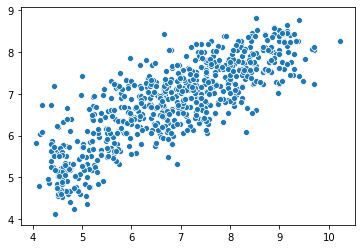

In [28]:
show_regressor_metrics(mlp_reg2, X_test, y_test)

## Binary classification

#### Reload data

In [45]:
data = pd.read_csv('data/CHEMBL206_ERA_ligands_activity_IC50_preprocessed.csv')
f = [x for x in data['FP2']]
f = [np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in f]
data['FP2'] = f

labels = data['label'].values == 'active'

train, test = train_test_split(data, test_size=0.3, random_state=666)
train, test = train.copy(), test.copy()

X_train = np.asarray([fp for fp in train['FP2']])
X_test = np.asarray([fp for fp in test['FP2']])
y_train = [value for value in train['label']]
y_test = [value for value in test['label']]

#### Metrics function

In [46]:
def show_classifier_metrics(y_pred, y_test):
    print('Accuracy: {:.3f}\n'.format(accuracy_score(y_test, y_pred)))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    print('                   actual active    actual inactive')
    print('predicted active   {:13d}    {:13d}'.format(tp, fp))
    print('predicted inactive {:13d}    {:13d}'.format(fn, tn))

### Logistic regression

In [352]:
lrc = LogisticRegression(C=1.3).fit(X_train, y_train)
show_classifier_metrics(lrc.predict(X_test), y_test)

Accuracy: 0.823

                   actual active    actual inactive
predicted active             218               65
predicted inactive            57              351


/home/jirka/miniconda3/envs/pnl/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Random Forests

In [313]:
rfc = RandomForestClassifier(n_estimators = 40)
rfc.fit(X_train, y_train)
show_classifier_metrics(rfc.predict(X_test), y_test)

Accuracy: 0.812

                   actual active    actual inactive
predicted active             212               62
predicted inactive            67              347


### Gaussian Naive Bayes

#### Parameter tuning

In [355]:
gnbc_params = {'var_smoothing': [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]}

gnbc = GridSearchCV(GaussianNB(), param_grid=gnbc_params, cv=3)
gnbc.fit(X_train, y_train)
show_classifier_metrics(gnbc.predict(X_test), y_test)

best_parameters=gnbc.best_estimator_.get_params()
for param_name in sorted(gnbc_params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Accuracy: 0.815

                   actual active    actual inactive
predicted active             202               55
predicted inactive            73              361
	var_smoothing: 0.01


### Keras Sequential model

#### Reload dataset

In [356]:
data = pd.read_csv('data/CHEMBL206_ERA_ligands_activity_IC50_preprocessed.csv')
f = [x for x in data['FP2']]
f = [np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in f]
data['FP2'] = f

labels = data['label'].values == 'active'
data['binary_label'] = labels

train, test = train_test_split(data, test_size=0.3, random_state=666)
train, test = train.copy(), test.copy()

X_train = np.asarray([fp for fp in train['FP2']])
X_test  = np.asarray([fp for fp in test['FP2']])

y_train = np.asarray([value for value in train['binary_label']])
y_test  = np.asarray([value for value in test['binary_label']])


In [357]:
ksm = Sequential()
ksm.add(Dense(units=256, activation='relu', input_dim=1024))
ksm.add(Dense(units=1, activation='sigmoid'))
ksm.compile(loss=binary_crossentropy, optimizer=Adam(lr=0.01), metrics=['accuracy'])
history = ksm.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1610/1610 [==============================] - 4s 2ms/step - loss: 0.4661 - acc: 0.7702
Epoch 2/10
1610/1610 [==============================] - 0s 247us/step - loss: 0.3148 - acc: 0.8522
Epoch 3/10
1610/1610 [==============================] - 0s 277us/step - loss: 0.2568 - acc: 0.8870
Epoch 4/10
1610/1610 [==============================] - 0s 243us/step - loss: 0.2415 - acc: 0.8888
Epoch 5/10
1610/1610 [==============================] - 0s 223us/step - loss: 0.2256 - acc: 0.9025
Epoch 6/10
1610/1610 [==============================] - 0s 221us/step - loss: 0.1901 - acc: 0.9137
Epoch 7/10
1610/1610 [==============================] - 0s 216us/step - loss: 0.1700 - acc: 0.9255
Epoch 8/10
1610/1610 [==============================] - 0s 258us/step - loss: 0.1547 - acc: 0.9348
Epoch 9/10
1610/1610 [==============================] - 0s 214us/step - loss: 0.1598 - acc: 0.9224
Epoch 10/10
1610/1610 [==============================] - 0s 215us/step - loss: 0.1377 - acc: 0.9366


Accuracy: 0.829

                   actual active    actual inactive
predicted active             364               66
predicted inactive            52              209


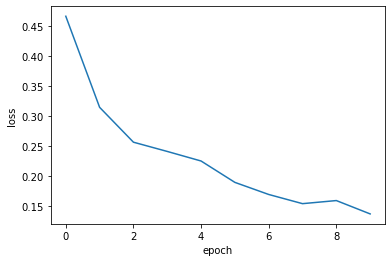

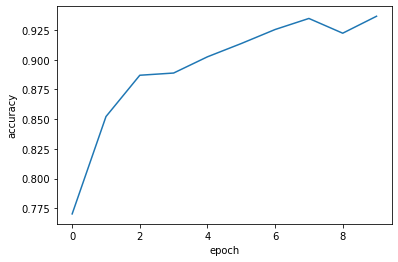

In [358]:
plt.figure()
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(history.epoch, history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

show_classifier_metrics(ksm.predict(X_test)>.5, y_test)

## Appendix: visualization of ligands within chemical space

Chemical space is here represented by a representative subset of 1000 molecules from the [ZINC database](http://zinc.docking.org/)

#### Reload and restandardize target receptor ligand data

In [317]:
data = pd.read_csv('data/CHEMBL206_ERA_ligands_activity_IC50_preprocessed.csv')
data['Standardized'] = [standardization(Chem.MolFromSmiles(mol)) for mol in data['Canonical_Smiles']]

RDKit ERROR: [23:23:33] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [23:23:33] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [23:23:33] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [23:23:33] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [23:23:33] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


#### Load and standardize representative subset

In [318]:
zinc_data = pd.read_csv('data/zincs1000.smi')
zinc_data['Standardized'] = [standardization(Chem.MolFromSmiles(mol)) for mol in zinc_data['Canonical_Smiles']]

#### Add dataset label and merge datasets

In [319]:
zinc_data['label'] = 'ZINC1000'

In [320]:
data_merged = pd.concat([zinc_data, data[['Canonical_Smiles', 'Standardized', 'label']]])

#### Calculate descriptors

In [321]:
lip_func = [Lipinski.NumHAcceptors, Lipinski.NumHDonors, Descriptors.ExactMolWt, Descriptors.MolLogP,
           rdMolDescriptors.CalcTPSA, Lipinski.NumRotatableBonds]
lip_func_names = ['Lipinski.NumHAcceptors', 'Lipinski.NumHDonors', 'Descriptors.ExactMolWt', 'Descriptors.MolLogP',
           'rdMolDescriptors.CalcTPSA', 'Lipinski.NumRotatableBonds']

In [322]:
for f, fname in zip(lip_func, lip_func_names):
    data_merged[fname] = data_merged['Standardized'].apply(f)

In [323]:
data_merged.head()

,Canonical_Smiles,Standardized,label,Lipinski.NumHAcceptors,Lipinski.NumHDonors,Descriptors.ExactMolWt,Descriptors.MolLogP,rdMolDescriptors.CalcTPSA,Lipinski.NumRotatableBonds
0,CN(C)CC(=O)NCc1cccc(OCc2ccccc2)c1,<rdkit.Chem.rdchem.Mol object at 0x7f45c1421818>,ZINC1000,3,1,298.168128,2.4434,41.57,7
1,CSCCN1CCC(C(=O)c2ccc3c(c2)NC(=O)C(C)O3)CC1,<rdkit.Chem.rdchem.Mol object at 0x7f45c1421710>,ZINC1000,5,1,348.150764,2.6637,58.64,5
2,CC(=O)N1CCCCC1C(=O)NC1CCCN(c2ncccn2)C1,<rdkit.Chem.rdchem.Mol object at 0x7f45c1421870>,ZINC1000,5,1,331.200825,0.9626,78.43,3
3,CNC(=O)C1(C)CCN(C(=O)c2csc(-c3cnn(-c4ccccc4)c3...,<rdkit.Chem.rdchem.Mol object at 0x7f45c14218c8>,ZINC1000,6,1,395.141596,2.5940,80.12,4
4,Fc1ccc2nc(-c3cccc(Cl)c3)sc2c1,<rdkit.Chem.rdchem.Mol object at 0x7f45c1421920>,ZINC1000,2,0,262.997176,4.7558,12.89,1


AxesSubplot(0.125,0.11;0.775x0.77)


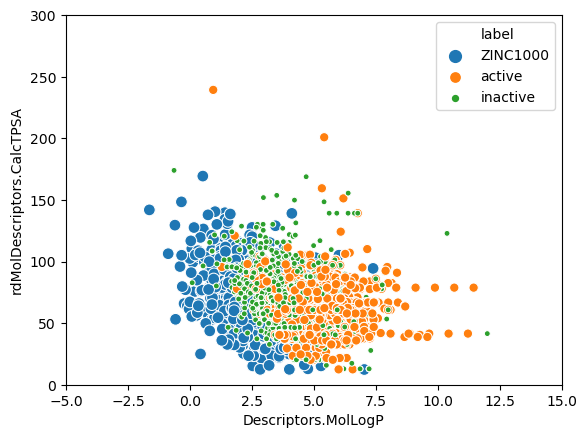

In [348]:
ax = sns.scatterplot(data = data_merged, x = 'Descriptors.MolLogP', y = 'rdMolDescriptors.CalcTPSA', hue = 'label', size='label')

ax.set(ylim=(0, 300), xlim=(-5, 15))
print(ax)

AxesSubplot(0.125,0.11;0.775x0.77)


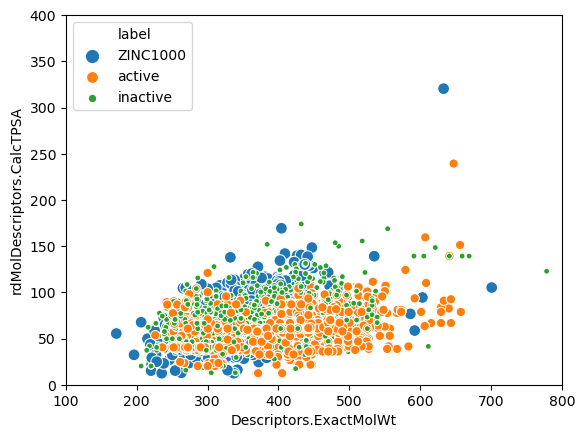

In [349]:
ax = sns.scatterplot(data = data_merged,
                     x = 'Descriptors.ExactMolWt',
                     y = 'rdMolDescriptors.CalcTPSA',
                     hue = 'label',
                     size = 'label')

ax.set(ylim=(0, 400), xlim=(100,800))
print(ax)

#### PCA

In [335]:
for f, fname in zip(lip_func, lip_func_names):
    data[fname] = data['Standardized'].apply(f)

In [336]:
data_scaled = scale(data[lip_func_names])

In [337]:
pca = PCA()
pca.fit(data_scaled)
data_PCA = pd.DataFrame(pca.transform(data_scaled), columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
label = [x for x in data['label']]
data_PCA['label'] = label

In [338]:
data_PCA.head()

,PC1,PC2,PC3,PC4,PC5,PC6,label
0,-1.254246,0.014103,0.234211,-0.062773,-0.033451,-0.032305,active
1,-1.480846,0.350436,0.183985,0.003046,0.075670,0.006740,active
2,-1.150367,-0.378650,0.235642,0.136540,-0.159793,-0.018202,active
3,0.194186,1.228582,0.091901,0.092483,0.630842,-0.084511,active
4,0.060498,1.553832,0.029642,0.142528,0.569686,-0.119324,active


/home/jirka/miniconda3/envs/pnl/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/jirka/miniconda3/envs/pnl/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/jirka/miniconda3/envs/pnl/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/jirka/miniconda3/envs/pnl/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/jirka/miniconda3/envs/pnl/lib/python3.7/_collectio

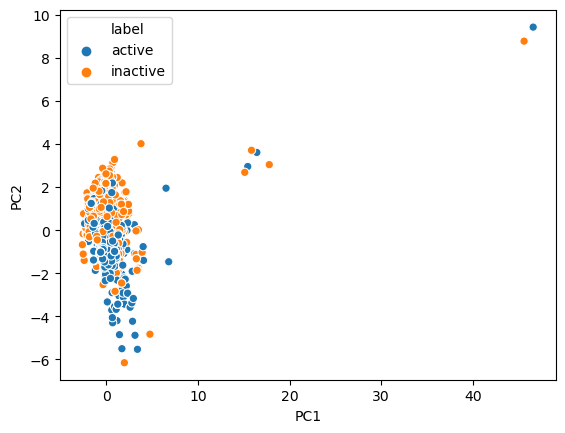

In [345]:
sns.reset_orig()
ax = sns.scatterplot(data = data_PCA,
                     x = 'PC1',
                     y = 'PC2',
                     hue = 'label')


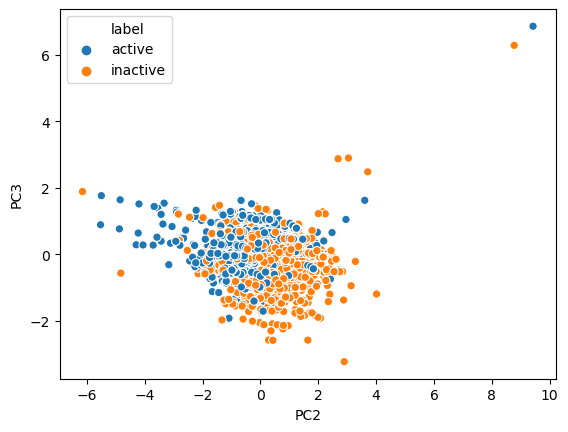

In [346]:
ax = sns.scatterplot(data = data_PCA,
                     x = 'PC2',
                     y = 'PC3',
                     hue = 'label')

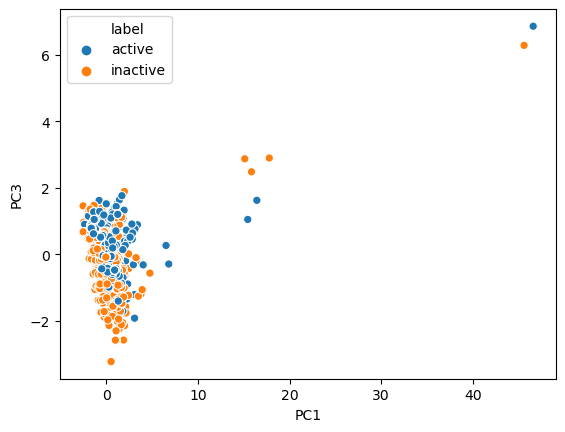

In [347]:
ax = sns.scatterplot(data = data_PCA,
                     x = 'PC1',
                     y = 'PC3',
                     hue = 'label')